In [5]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [6]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I had the misfortune to watch this rubbish on Sky Cinema Max in a cold winter night. I am not a big fan of horror movies, because most of them are just trash. This one is even worse: it is one of the dumbest pieces of crap i've ever seen in my whole life. Horror movie? Yes, there are horrible things in this: the acting, the script and the special effects - Gosh, i laughed at this ludicrous attempt to make a flick for 90 minutes. Actually, had it been a comic movie i would've given it a 5. Don't you even think about renting this unless you want to mock at the producers.<br /><br />Vote: 2 out of 10 - didn't vote one because it made me laugh all the time ;-)"
 b"This had to be one of the worst movies I've ever seen and I'm 64 years old and a football fan. I went expecting to see a football movie. About 10 minutes into it, I began to wonder exactly how such a bad movie (particularly the acting) could have gotten into a theater. About half way through, I whispered to my husband 

In [11]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [13]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[10, 67,  2, ...,  0,  0,  0],
       [11, 67,  6, ...,  0,  0,  0],
       [11, 20,  1, ...,  0,  0,  0]])

In [14]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I had the misfortune to watch this rubbish on Sky Cinema Max in a cold winter night. I am not a big fan of horror movies, because most of them are just trash. This one is even worse: it is one of the dumbest pieces of crap i've ever seen in my whole life. Horror movie? Yes, there are horrible things in this: the acting, the script and the special effects - Gosh, i laughed at this ludicrous attempt to make a flick for 90 minutes. Actually, had it been a comic movie i would've given it a 5. Don't you even think about renting this unless you want to mock at the producers.<br /><br />Vote: 2 out of 10 - didn't vote one because it made me laugh all the time ;-)"
Round-trip:  i had the [UNK] to watch this [UNK] on [UNK] cinema [UNK] in a [UNK] [UNK] night i am not a big fan of horror movies because most of them are just [UNK] this one is even worse it is one of the [UNK] [UNK] of crap ive ever seen in my whole life horror movie yes there are horrible things in this the acting th

In [15]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [16]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)



Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.8734 - loss: 0.2942 - val_accuracy: 0.8427 - val_loss: 0.3235
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.8713 - loss: 0.2966 - val_accuracy: 0.8536 - val_loss: 0.3175
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 57ms/step - accuracy: 0.8767 - loss: 0.2877 - val_accuracy: 0.8484 - val_loss: 0.3175
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8806 - loss: 0.2790 - val_accuracy: 0.8630 - val_loss: 0.3211
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.8778 - loss: 0.2811 - val_accuracy: 0.8594 - val_loss: 0.3199
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.8855 - loss: 0.2689 - val_accuracy: 0.8401 - val_loss: 0.3313
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.8773 - loss: 0.2794 - val_accuracy: 0.8453 - val_loss: 0.3274
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.8840 - loss: 0.2686 

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.8853 - loss: 0.2629 - val_accuracy: 0.8677 - val_loss: 0.3446
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.8906 - loss: 0.2565 - val_accuracy: 0.8427 - val_loss: 0.3403
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.8894 - loss: 0.2568 - val_accuracy: 0.8339 - val_loss: 0.3496
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.8923 - loss: 0.2496 - val_accuracy: 0.8635 - val_loss: 0.3428
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.8943 - loss: 0.2454 - val_accuracy: 0.8578 - val_loss: 0.3378
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.8933 - loss: 0.2505 - val_accuracy: 0.8635 - val_loss: 0.3513
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8934 - loss: 0.2443 - val_accuracy: 0.8521 - val_loss: 0.3500
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8971 - loss: 0.2397 

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.8610 - loss: 0.3502
Test Loss: 0.3499099910259247
Test Accuracy: 0.8596000075340271


(0.0, 0.38463917598128317)

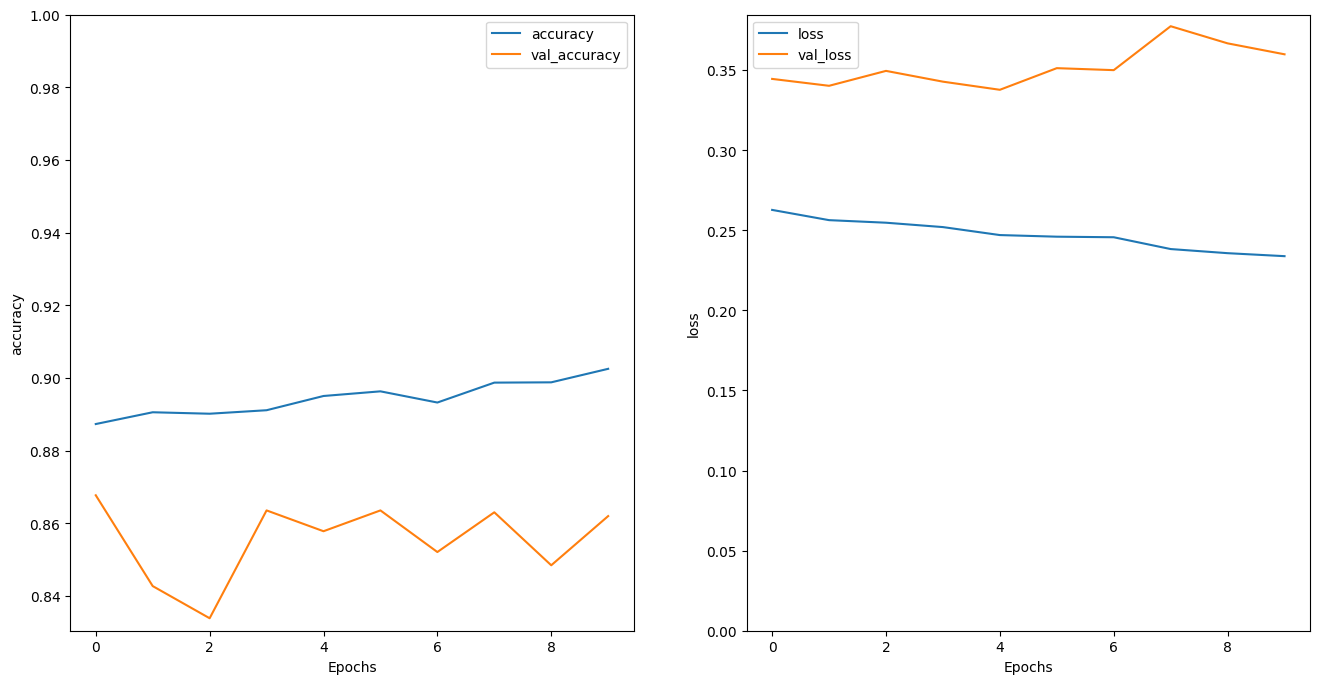

In [27]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [29]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [31]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.5078 - loss: 0.6875 - val_accuracy: 0.7354 - val_loss: 0.4945
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 101ms/step - accuracy: 0.7977 - loss: 0.4423 - val_accuracy: 0.8328 - val_loss: 0.4164
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.8419 - loss: 0.3659 - val_accuracy: 0.8266 - val_loss: 0.3639
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.8556 - loss: 0.3399 - val_accuracy: 0.8495 - val_loss: 0.3348
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8681 - loss: 0.3129 - val_accuracy: 0.8536 - val_loss: 0.3272
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.8689 - loss: 0.3084 - val_accuracy: 0.8568 - val_loss: 0.3240
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.8664 - loss: 0.3106 - val_accuracy: 0.8536 - val_loss: 0.3209
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.8681 - loss: 0.3092

In [32]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8359 - loss: 0.3307
Test Loss: 0.3294169008731842
Test Accuracy: 0.8357200026512146


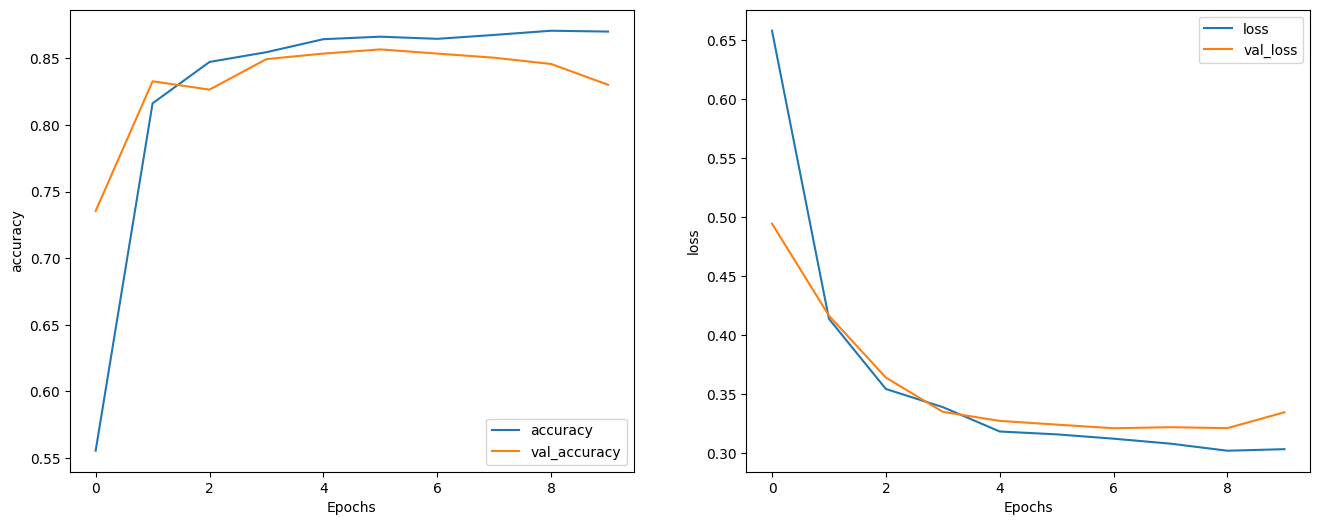

In [34]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')